# Digital Up & Down Conversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rfproto import measurements, nco, plot, sig_gen

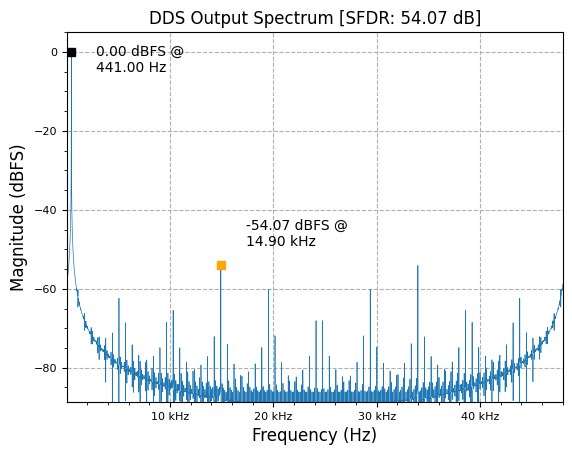

In [2]:
f  = 440.5 # desired output frequency
n  = 48000 # number of output points to compute
fs = 48000 # sampling frequency
N  = 32    # phase accumulator length (num bits)
P  = 9     # LUT table address length (total depth = 2^P)
M  = 16    # quantized word length (num bits)

test_NCO = nco.Nco(N, M, P, fs)

y = np.zeros(n) + 1j*np.zeros(n)
test_NCO.SetOutputFreq(f)
for i in range (n):
    # just take imag part (starts at 0) for this
    y[i] = test_NCO.Step()

plot.spec_an(y, fs, "DDS Output Spectrum", scale_noise=True, real=False, norm=True)
plt.show()

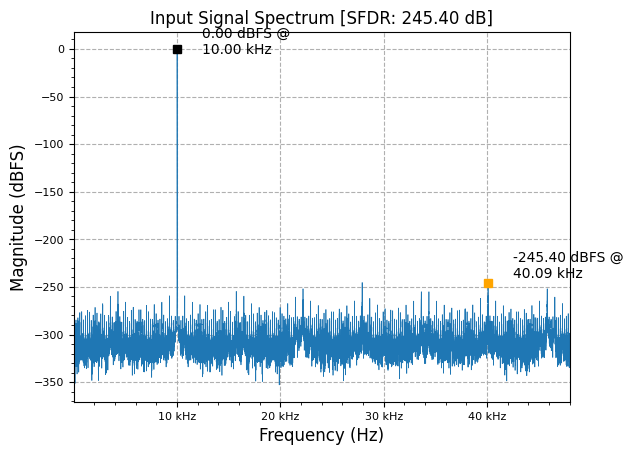

In [3]:
input_sig = sig_gen.cmplx_dt_sinusoid(2**15, 10000, fs, n)
plot.spec_an(input_sig, fs, "Input Signal Spectrum", scale_noise=False, real=False, norm=True)
plt.show()

Complex NCO- which acts as discrete-time form of analog heterodyne system's Local Oscillator (LO)- allows us to mix an input signal up or down in frequency, without worrying about images that would occur with a real-valued NCO (e.g. real valued NCO has frequencies at both $\pm f$). The process can be seen as:
$$ A_{NCO}e^{j\omega_{NCO}t} * A_{sig}e^{j\omega{sig}t} = A_{NCO}A_{sig}e^{jt(\omega{sig}+\omega_{NCO})} $$
It can be seen that mixing adds frequencies, causing an associated shift upwards in total signal output frequency of $f_{NCO} + f_{sig}$.

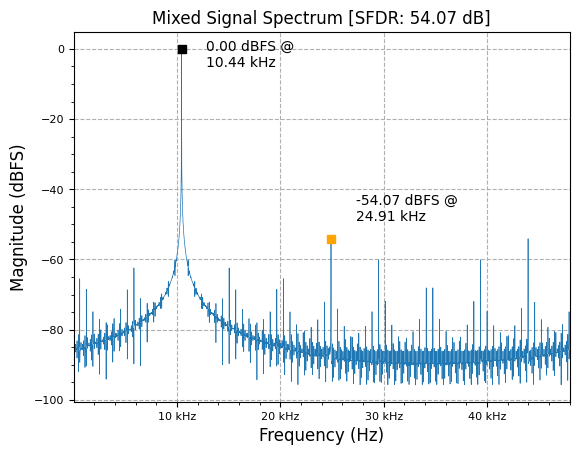

In [4]:
mixed = np.zeros(n) + 1j*np.zeros(n)

for i in range(n):
    # NOTE: conj(NCO output) moves mixed signal down, while input * y moves signal up
    mixed[i] = input_sig[i] * y[i]

# NOTE: since both input signal and NCO are complex, there are no images created in mixing
plot.spec_an(mixed, fs, "Mixed Signal Spectrum", scale_noise=False, real=False, norm=True)
plt.show()

To shift the output frequency down, we can simply take the complex conjugate of the NCO output (e.g. $z=e^{j\omega t}\rightarrow \overline{z}=e^{-j\omega t}$ ) to create a "negative" frequency, since:
$$ \overline{A_{NCO}e^{j\omega_{NCO}t}} * A_{sig}e^{j\omega{sig}t} = A_{NCO}A_{sig}e^{jt(\omega{sig}-\omega_{NCO})} $$
This mixing subtracts frequencies, causing an associated shift downwards in total signal output frequency of $f_{sig} - f_{NCO}$.

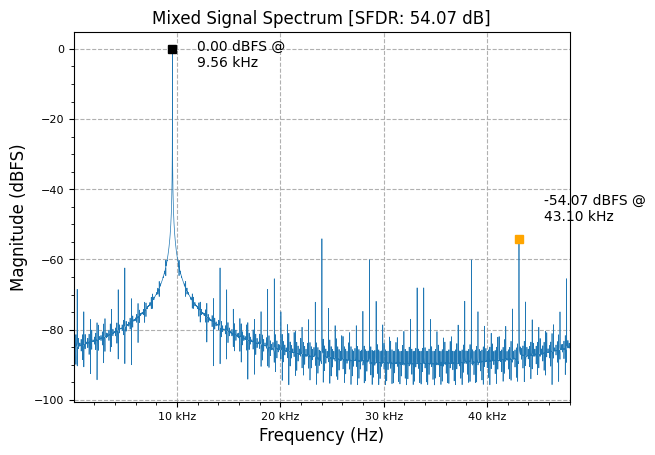

In [5]:
mixed = np.zeros(n) + 1j*np.zeros(n)

for i in range(n):
    mixed[i] = input_sig[i] * np.conj(y[i])

plot.spec_an(mixed, fs, "Mixed Signal Spectrum", scale_noise=False, real=False, norm=True)
plt.show()

## $f_{s}/4$ Simplification

`#TODO:` when mixer equals $f_{s}/2$ or $f_{s}/4$, can just use alternating `+/-1` (for $f_{s}/2$) or `+1,0,-1,0` (for $f_{s}/4$) very cheaply! Can also be used in lieu of `fftshift()` type applications.

* [DSP Trick: Complex Downconverters for Signals at Fs/4 or 3Fs/4 - DSP Guru](http://dspguru.com/dsp/tricks/complex-downconverters-at-fs-over-4/)

## Transmit Simplification

Since Digital-to-Analog Converters (DACs) operate on real digital data (real input to real analog output)- except in [direct conversion (zero IF)](https://wirelesspi.com/direct-conversion-zero-if-receiver/) front ends- we only need the real output of a digital upconverter (DUC), either $I$ or $Q$. In this case, we can simplify the digital mixer (the complex multiplier used to combine the NCO output and transmit I/Q stream) to not have to compute the full complex product (requiring 4x multiplies), but rather just the $I$ term (2x multiplies) as:
$$Y_{DUC} = (I_{NCO} + jQ_{NCO})(I_{TX} + jQ_{TX})$$
$$Y_{DUC} = \underline{(I_{NCO}I_{TX} - Q_{NCO}Q_{TX})} + \cancel{j(I_{NCO}Q_{TX} + I_{TX}Q_{NCO})}$$

## References

* [DUC/DDC Compiler - AMD/Xilinx](https://docs.xilinx.com/v/u/en-US/pg147-duc-ddc-compiler)
* [Designing DDC systems using CIC and FIR Filters - Intel/Altera](https://www.intel.com/content/www/us/en/support/programmable/support-resources/design-examples/horizontal/exm-digital-down-conv-cic-fir.html)
* [DUC/DDC MATLAB](https://www.mathworks.com/help/dsp/ug/digital-up-and-down-conversion-for-family-radio-service.html)
* [Designing Efficient Digital Up and Down Converters for Narrowband Systems - Xilinx](https://docs.xilinx.com/v/u/en-US/xapp1113)
* [What's Up with Digital Downconverters Part I - ADI](https://www.analog.com/en/analog-dialogue/articles/whats-up-with-digital-downconverters-part-1.html)
* [What's Up with Digital Downconverters Part II - ADI](https://www.analog.com/en/analog-dialogue/articles/whats-up-with-digital-downconverters-part-2.html)
* [Complex RF Mixers, Zero-IF Architecture, and Advanced Algorithms: The Black Magic in Next-Generation SDR Transceivers - ADI](https://www.analog.com/en/analog-dialogue/articles/complex-mixers-zif-architecture-advanced-algorithms-black-magic-next-generation-sdr-transceivers.html)